In [1]:
import glob
from utils import segnn_utils
import os
import numpy as np
import torch
import sys
from datasets.nbody.dataset_gravity import GravityDataset
import importlib
import json
from types import SimpleNamespace

torch.manual_seed(42)

print(sys.executable)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#run = os.path.join("segnn_runs", "2024-03-18 18-38_gravityV2_segnn")
run = os.path.join("segnn_runs", "2024-03-20 11-01_gravityV2_segnn")

# training args
metadata_path = os.path.join(run, 'training_args.json')
if os.path.exists(metadata_path):
    with open(metadata_path, 'r') as json_file:
        args_dict = json.load(json_file)
    args = SimpleNamespace(**args_dict)
    args = SimpleNamespace(**args.args)

models = glob.glob(run + "/" + '*.pth')
if len(models) > 1:
    print("MORE MODELS FOUND IN THE DIR, LOADING THE FIRST:", models[0])

model = torch.load(models[0], map_location=device)

dataset = GravityDataset(partition='test', dataset_name=args.nbody_name,
                         max_samples=args.max_samples, neighbours=args.neighbours, target=args.target,
                         path=os.path.join(run, "gravity"))

t_delta = 2
loc, vel, force, mass = dataset.data
dims = loc.shape[-1]
boxSize = 5
particle_index = None

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3_10\python.exe


# Getting prediction from batches, where a batch is all steps of a single simulation



In [2]:
from utils import segnn_utils

sim_indices = (i for i in range(3))
batch_simulations_predictions = segnn_utils.batch_prediction(model, dataset.data, args, device,
                                                             simulation_indices=sim_indices)

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3_10\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


# Plot the whole simulation

In [3]:
simulation_index = 0

batch_simulations_predicted_position_changes = batch_simulations_predictions[simulation_index, ..., :dims]
batch_simulations_predicted_positions = loc[simulation_index] + batch_simulations_predicted_position_changes

batch_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index, t_delta=t_delta)

dataset.simulation.interactive_trajectory_plot_all_particles_3d(batch_targets,
                                                                batch_simulations_predicted_positions,
                                                                particle_index,
                                                                boxSize=boxSize, dims=dims,
                                                                offline_plot=False)

Showing plot, you might need to bring the plot window in focus


# SELFFEED STEPWISE (len jedna simulacia, nie batch simulacii)


In [4]:
sim_indices = (i for i in range(5))
steps = 200

importlib.reload(segnn_utils)

self_feed_pos, self_feed_vel, self_feed_force = segnn_utils.self_feed_stepwise_prediction(
    model,
    dataset.data,
    dataset.simulation,
    args, device,
    simulation_indices=sim_indices,
    steps=steps)

Simulating 0 Using force: False
Simulating 1 Using force: False
Simulating 2 Using force: False
Simulating 3 Using force: False
Simulating 4 Using force: False


### selffeed stepwise results

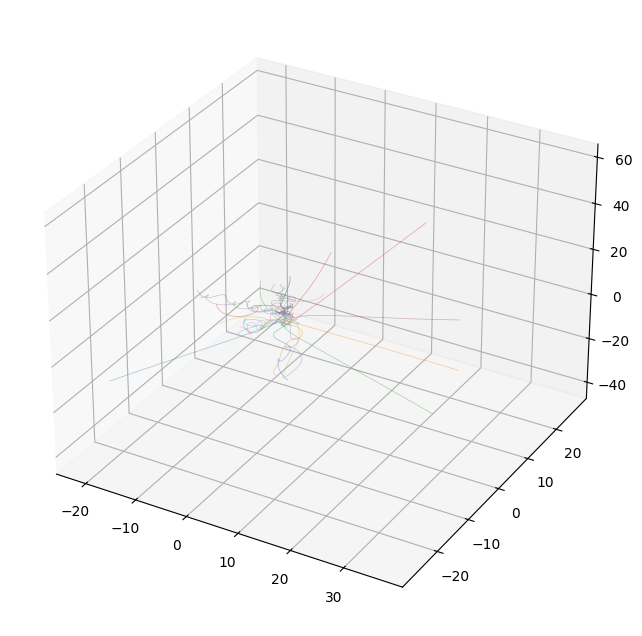

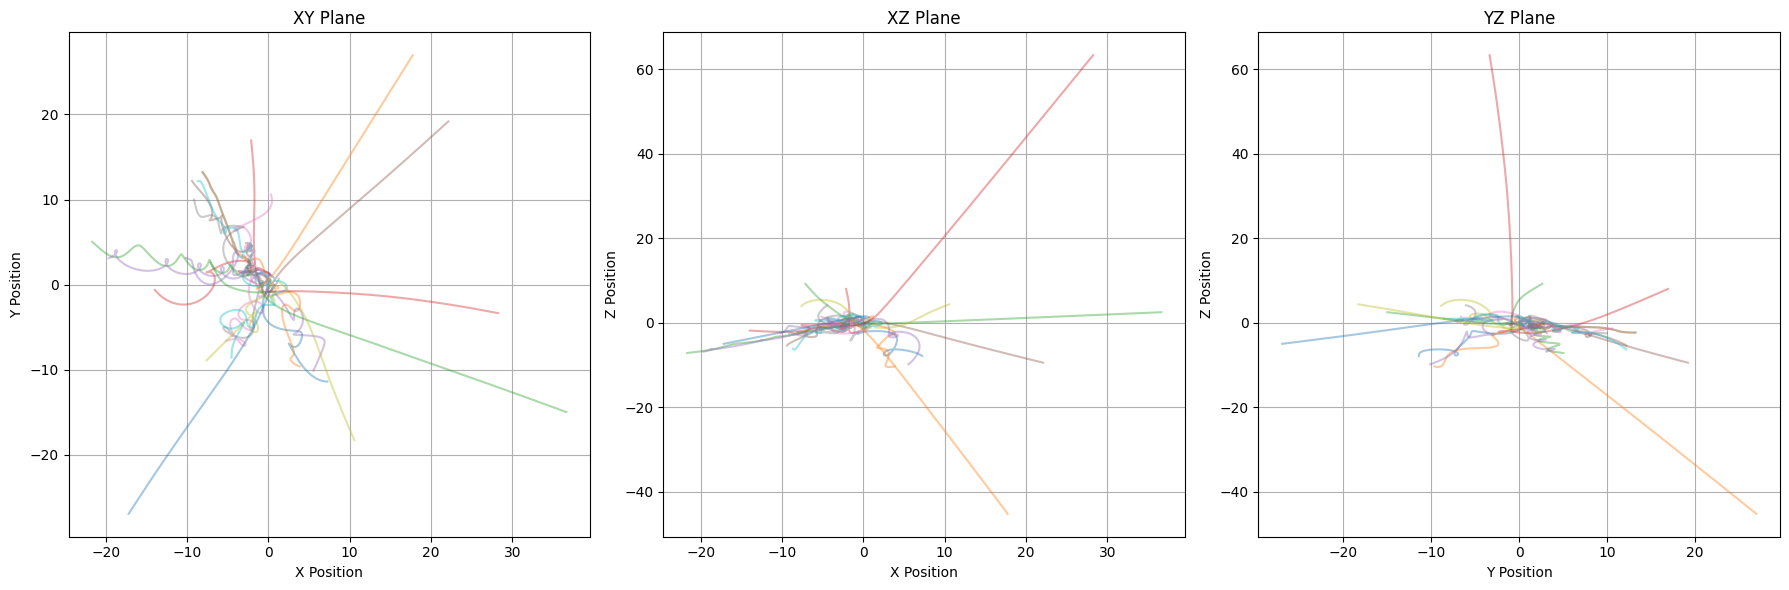

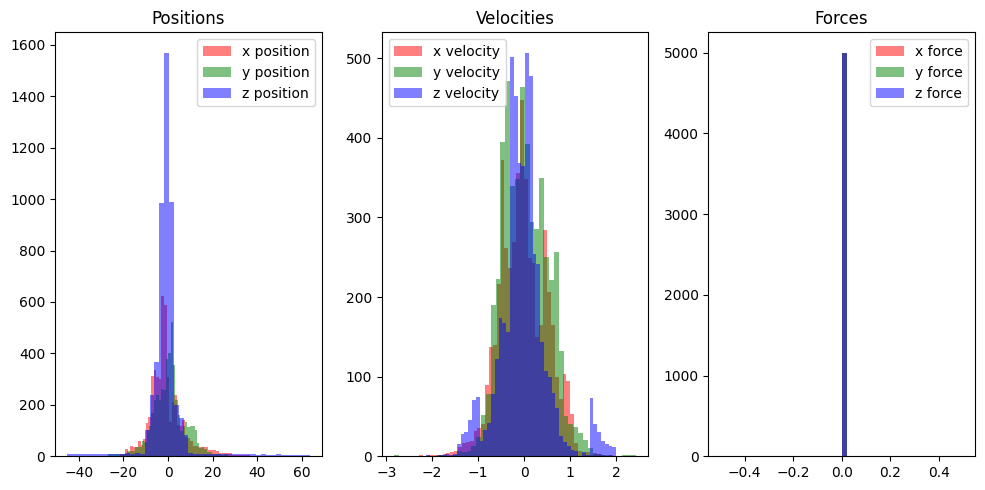

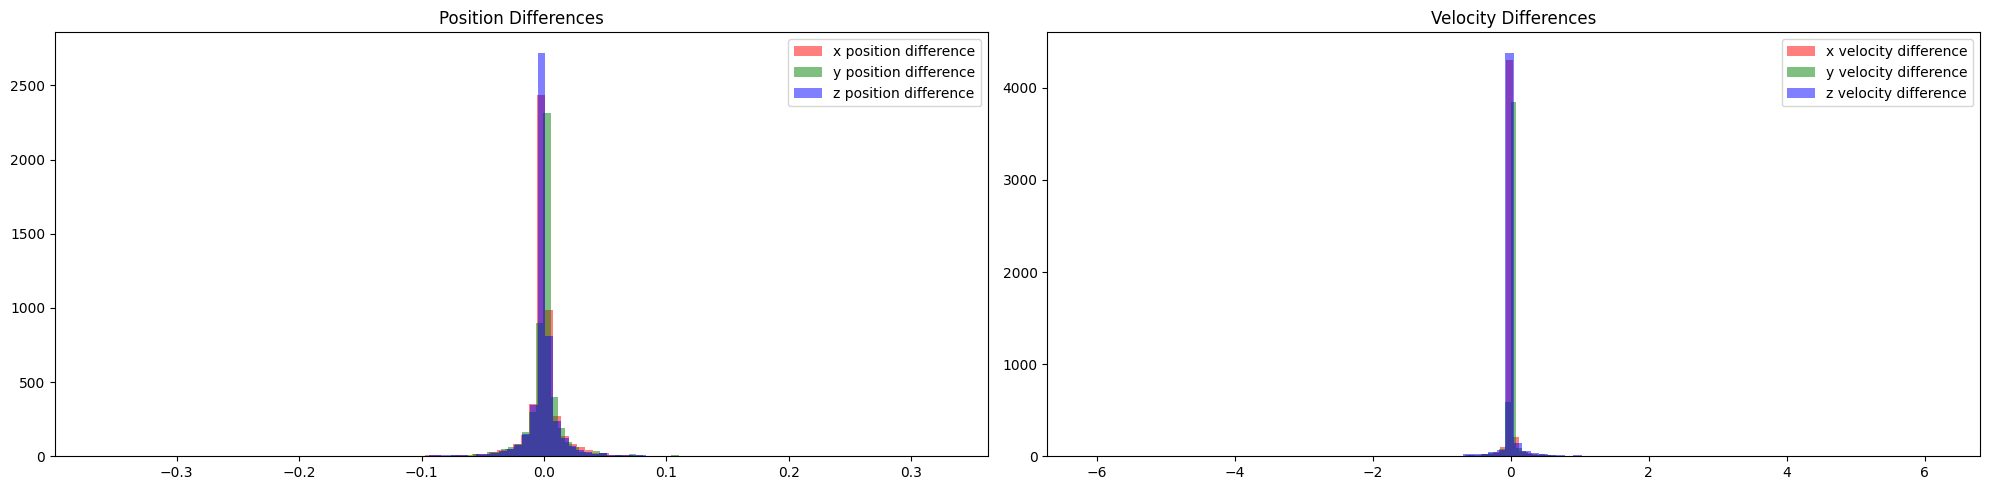

In [5]:
%matplotlib inline
# I suppose this is useless but if anyone wanted to see the actual data
dataset.plot_trajectories_static(self_feed_pos, max_sims=100)
# also in 2d
dataset.plot_trajectories_static_3D_to_2D(self_feed_pos, max_sims=100)

# plot distribution of all simulations
dataset.plot_histograms(self_feed_pos, self_feed_vel, self_feed_force, bins=50)

# also plot distribution of differences
dataset.plot_differences(self_feed_pos, self_feed_vel, step=2, bins=100)

This can take a while...


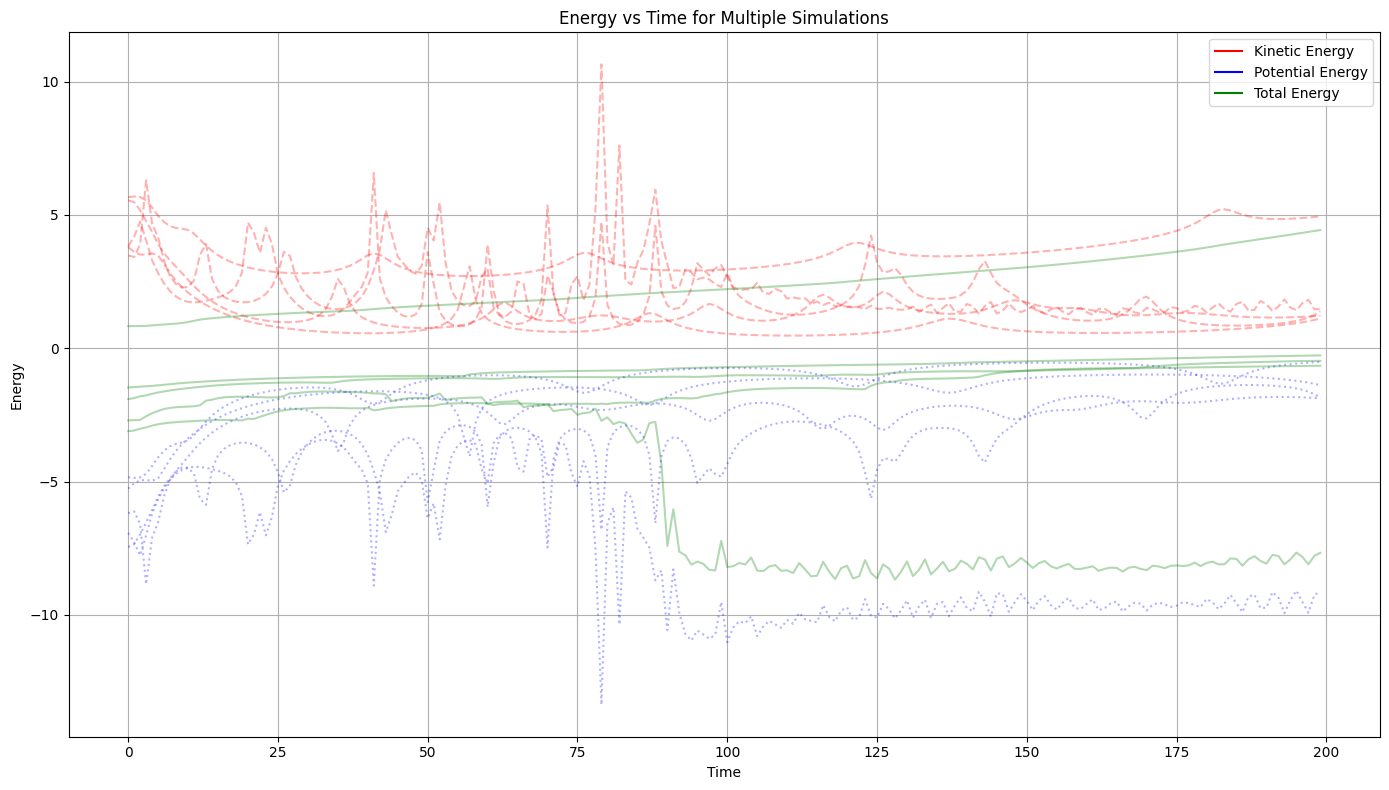

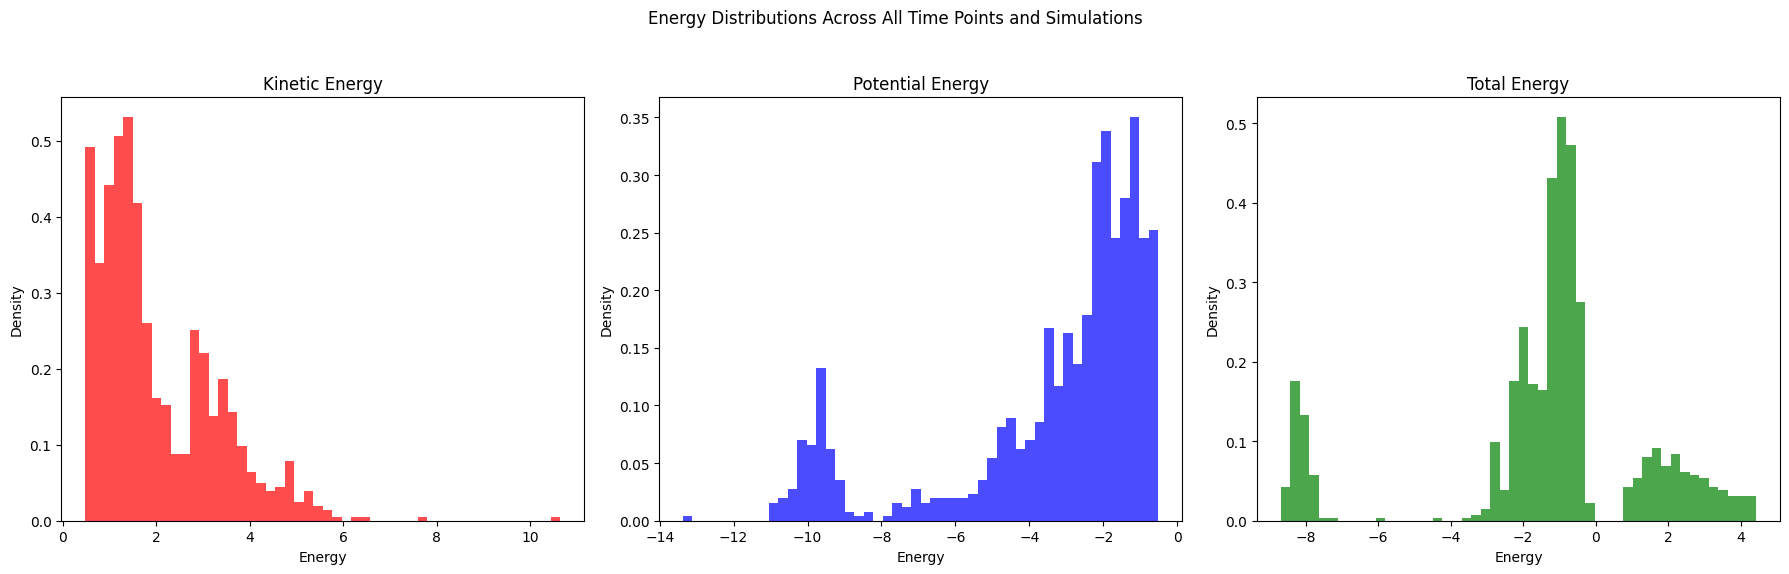

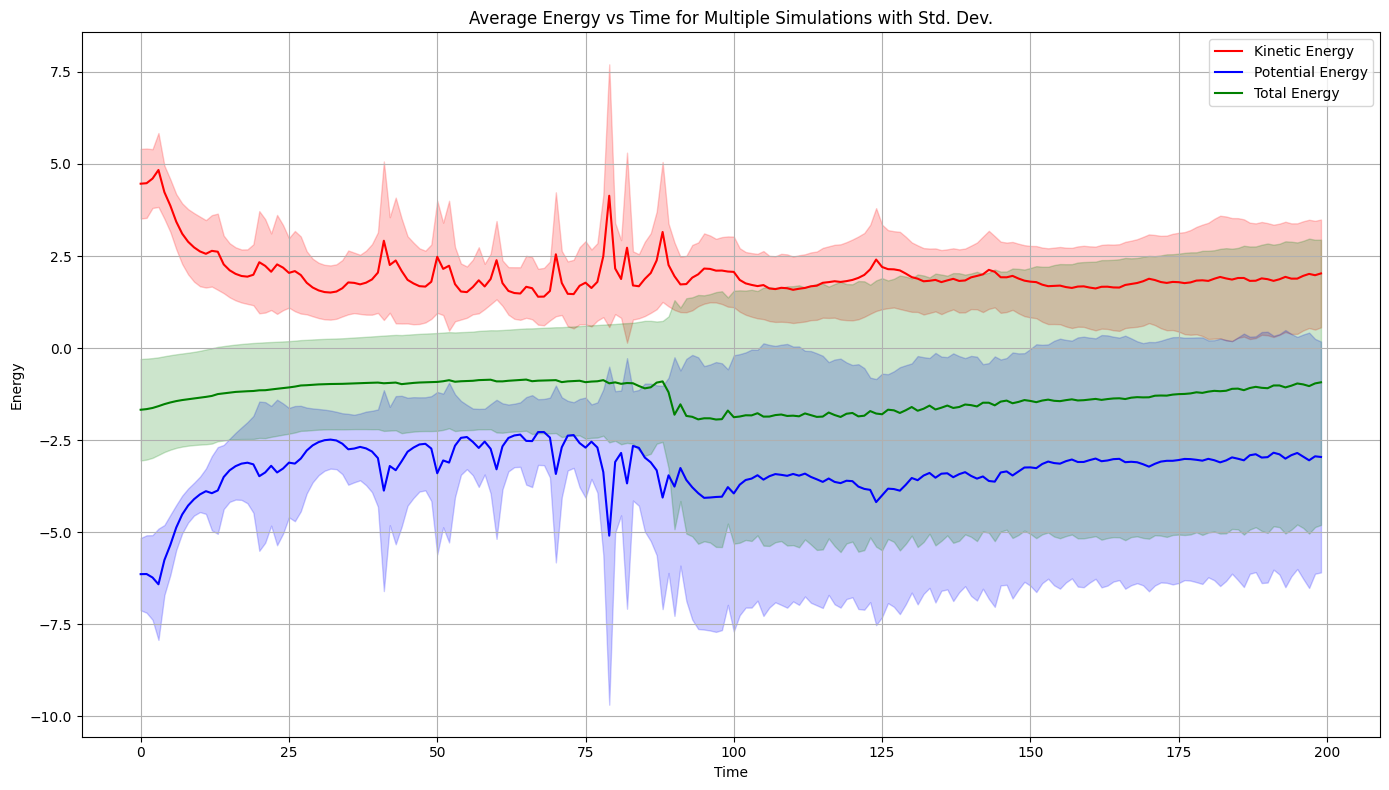

In [6]:
%matplotlib inline
# todo odstranit
# import datasets.nbody.dataset_gravity as dataset_gravity
# importlib.reload(dataset_gravity)
# 
# dataset = dataset_gravity.GravityDataset(partition='train', dataset_name=args.nbody_name,
#                                max_samples=args.max_samples, neighbours=args.neighbours, target=args.target,
#                                path=os.path.join(run, "gravity"))


# If anyone wondered how it looks like
print("This can take a while...")
dataset.plot_energies_of_all_sims(self_feed_pos, self_feed_vel, self_feed_force, mass)

# # distribution of energies of all simulations
dataset.plot_energy_distributions_across_all_sims(self_feed_pos, self_feed_vel, self_feed_force, mass)
# 
# # stats
dataset.plot_energy_statistics(self_feed_pos, self_feed_vel, self_feed_force, mass)

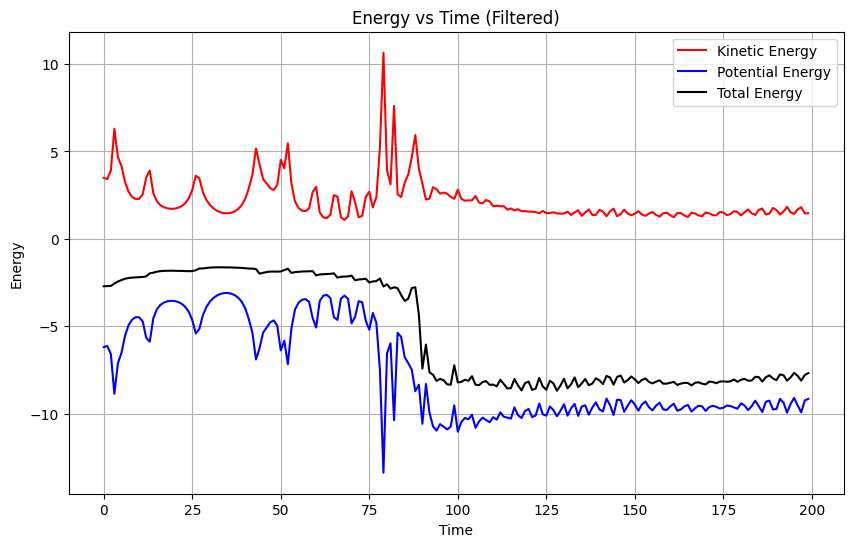

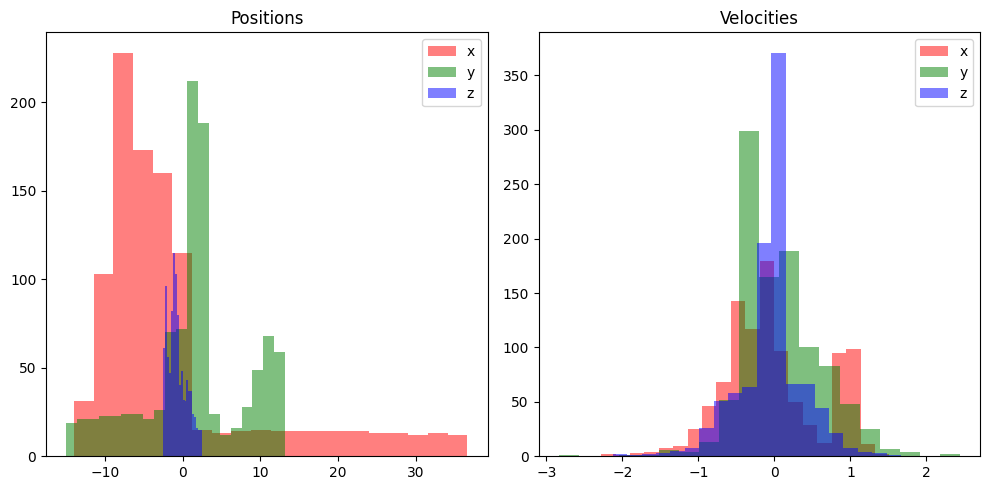

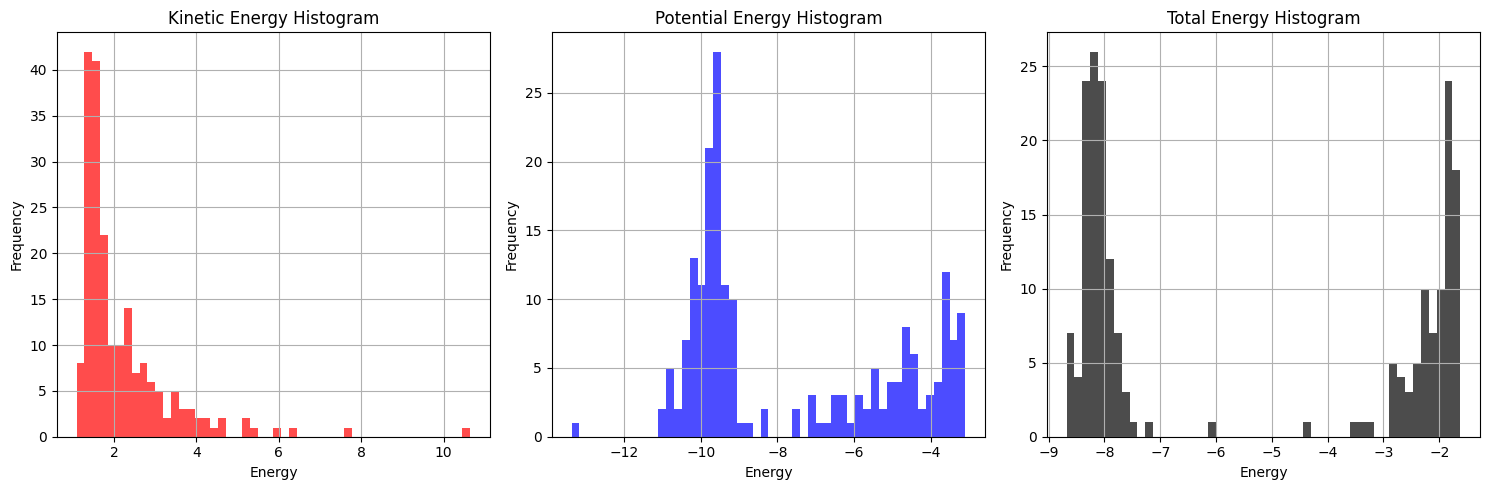

In [7]:
%matplotlib inline
simulation_index = 2
dataset.simulation.plot_energies(self_feed_pos[simulation_index], self_feed_vel[simulation_index],
                                 mass[simulation_index])
dataset.simulation.plot_histograms(self_feed_pos[simulation_index], self_feed_vel[simulation_index])
dataset.simulation.plot_energy_distribution(self_feed_pos[simulation_index], self_feed_vel[simulation_index],
                                            mass[simulation_index], bins=50)

In [13]:
particle_index = None
simulation_index = 2

self_feed_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index, t_delta=t_delta)

dataset.simulation.interactive_trajectory_plot_all_particles_3d(self_feed_targets,
                                                                self_feed_pos[simulation_index],
                                                                particle_index,
                                                                boxSize=10, dims=dims,
                                                                offline_plot=False, alpha=0.2)

Showing plot, you might need to bring the plot window in focus


# SELFFEED BATCH

In [9]:
importlib.reload(segnn_utils)
n_sims = 30
steps = 300

self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force = segnn_utils.self_feed_batch_prediction(model,
                                                                                                         dataset.data,
                                                                                                         dataset.simulation,
                                                                                                         args, device,
                                                                                                         n_sims=n_sims,
                                                                                                         steps=steps)

# selffeed batch results

In [11]:
particle_index = None
simulation_index = 2

self_feed_batch_targets = segnn_utils.get_targets(dataset.data, simulation_index=simulation_index,
                                                  t_delta=t_delta)
dataset.simulation.interactive_trajectory_plot_all_particles_3d(self_feed_batch_targets,
                                                                self_feed_batch_pos[simulation_index],
                                                                particle_index,
                                                                boxSize=10, dims=dims,
                                                                offline_plot=False, alpha=0.2)

Showing plot, you might need to bring the plot window in focus


In [14]:
print("This can take a while...")

dataset.plot_energies_of_all_sims(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)

# # distribution of energies of all simulations
dataset.plot_energy_distributions_across_all_sims(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)
# 
# # stats
dataset.plot_energy_statistics(self_feed_batch_pos, self_feed_batch_vel, self_feed_batch_force, mass)

This can take a while...


PicklingError: Can't pickle <class 'datasets.nbody.dataset.synthetic_sim.GravitySim'>: it's not the same object as datasets.nbody.dataset.synthetic_sim.GravitySim

# Compare batch and stepwise results


In [ ]:
importlib.reload(segnn_utils)
comparison_results = segnn_utils.compare_predictions(self_feed_batch_pos, self_feed_simulations_pos)

In [ ]:
(self_feed_batch_pos - self_feed_simulations_pos).mean()

In [ ]:
self_feed_batch_pos.mean()

In [ ]:
self_feed_simulations_pos.mean()

In [ ]:
predictions_np = np.stack(predictions)

pred_loc = predictions_np[..., :3]
pred_vel = predictions_np[..., 3:]
#preds_mass = mass.repeat(len(pred_vel), 1)
%matplotlib inline
sim.plot_trajectory_static(pred_loc)
sim.plot_energies(pred_loc, pred_vel, np.array(mass))
sim.plot_histograms(pred_loc, pred_vel)
sim.plot_energy_distribution(pred_loc, pred_vel, np.array(mass), bins=50)

In [ ]:


import matplotlib.pyplot as plt

num_dims = 3
opos = batch_prediction[..., :num_dims].reshape(50, 5, num_dims)
ovel = batch_prediction[..., num_dims:].reshape(50, 5, num_dims)


In [ ]:

plt.figure(figsize=(10, 5))

dim_labels = ['x', 'y', 'z'][:num_dims]  # Labels for dimensions
colors = ['red', 'green', 'blue'][:num_dims]  # Color for each dimension

# Positions
# plt.subplot(1, 2, 1)
for i, (color, label) in enumerate(zip(colors, dim_labels)):
    plt.hist(opos[:, :, i].flatten(), bins=50, alpha=0.5, color=color, label=f'{label}')
plt.title('Positions')
plt.legend()

# # Velocities
# plt.subplot(1, 2, 2)
# for i, (color, label) in enumerate(zip(colors, dim_labels)):
#     plt.hist(ovel[:, :, i].flatten(), bins=50, alpha=0.5, color=color, label=f'{label}')
# plt.title('Velocities')
# plt.legend()

#plt.tight_layout()
plt.show()